<a href="https://colab.research.google.com/github/Justinezgh/muse/blob/main/notebooks/Gaussinity_Study_LogNormal_Field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install --quiet jax-cosmo
!pip install --quiet numpyro
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 KB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%pylab inline
from functools import partial
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from chainconsumer import ChainConsumer
from sbi_lens.simulator.utils import (
    get_reference_sample_posterior_full_field,
    get_reference_sample_posterior_power_spectrum
)
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions
from jax.scipy.ndimage import map_coordinates

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [3]:
# Retrieving log normal parameters
!wget https://gist.githubusercontent.com/EiffL/071e11f7054ee918c18d0f8ad93085c6/raw/a4c830f03fa7baf3b34729bd8b8c51dccf0eae25/lognormal_shift.csv

--2023-03-27 13:05:07--  https://gist.githubusercontent.com/EiffL/071e11f7054ee918c18d0f8ad93085c6/raw/a4c830f03fa7baf3b34729bd8b8c51dccf0eae25/lognormal_shift.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2715 (2.7K) [text/plain]
Saving to: ‘lognormal_shift.csv’

lognormal_shift.csv 100%[===================>]   2.65K  --.-KB/s    in 0s      

2023-03-27 13:05:07 (49.5 MB/s) - ‘lognormal_shift.csv’ saved [2715/2715]



# Model

In [24]:
def make_plot(shift): 
  lognormal_params = np.loadtxt(
    "/content/lognormal_shift.csv",
    skiprows=1,
    delimiter=','
  )

  lognormal_params[:,2] = shift

  lognormal_params_ = lognormal_params.reshape([8, 8, 3])


  @jax.jit
  def shift_fn(omega_m, sigma_8):

    omega_m = jnp.atleast_1d(omega_m)
    sigma_8 = jnp.atleast_1d(sigma_8)
    lambda_shift = map_coordinates(lognormal_params_[:, :, 2],
                                  jnp.stack([(omega_m - 0.2) / 0.2 * 8 - 0.5,
                                              (sigma_8 - 0.6) / 0.4 * 8 - 0.5],
                                            axis=0).reshape([2, -1]),
                                  order=1,
                                  mode='nearest').squeeze()

    return lambda_shift


  def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0):

    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    power_map = ps_map * (N / map_size)**2
    return power_map


  def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):

    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(
        1 + power_spectrum_for_lognorm / shift**2
    )
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm)
    )
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return power_spectrum_for_lognorm

  def lensingLogNormal(N=128,
                     map_size=5,
                     gal_per_arcmin2=10,
                     sigma_e=0.26,
                     model_type='lognormal',
                     with_noise=True, 
                     non_gaussianity = 1):

    pix_area = (map_size * 60 / N)**2
    map_size = map_size / 180 * jnp.pi

    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05))

    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    ell_tab = jnp.logspace(0, 4.5, 128) 
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(
        k.flatten(), ell_tab, cell_tab
    ).reshape(k.shape)

    z = numpyro.sample(
        'z',
        dist.MultivariateNormal(
            loc=jnp.zeros((N, N)),
            precision_matrix= jnp.eye(N)
        )
    )

    power_map = make_power_map(P, N, map_size)

    if model_type == 'lognormal':
      shift =  shift_fn(cosmo.Omega_m, sigma_8)
      power_map = make_lognormal_power_map(power_map, shift)
    field = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
    field_before_transfo = numpyro.deterministic('field_before_transfo', field)
    if model_type == 'lognormal':
      field = shift * (jnp.exp(field - jnp.var(field) / 2) - 1)

    field_after_transfo = numpyro.deterministic('field_after_transfo', field)

    return field_after_transfo

  model = partial(lensingLogNormal,
              N=128,
              map_size=5,
              gal_per_arcmin2=30,
              sigma_e=0.2,
              model_type='lognormal', 
              non_gaussianity=0.01)
    
  @jax.vmap
  @jax.jit
  def samples_(key):
    cond_model = seed(model, key)
    model_trace = trace(cond_model).get_trace()
    sample = {
        'theta':
        jnp.stack(
            [model_trace['omega_c']['value'], model_trace['sigma_8']['value']],
            axis=-1),
        'field_before_transfo':
        model_trace['field_before_transfo']['value'],
        'field_after_transfo':
        model_trace['field_after_transfo']['value']
    }

    return sample

  res = samples_(jax.random.split(jax.random.PRNGKey(0), 1))
  print('____variance of the field before transfo:', jnp.var(res['field_before_transfo'][0]))
  fig, ax = plt.subplots(1,2, figsize=(10, 7))
  ax[0].set_title('field_before_transfo')
  ax[0].imshow(res['field_before_transfo'][0]);
  cb = fig.colorbar(ax[0].imshow(res['field_before_transfo'][0]), fraction=0.05, pad=0.05)
  cb.ax.tick_params(labelsize=10)
  ax[1].set_title('field_after_transfo')
  ax[1].imshow(res['field_after_transfo'][1]); 
  cb = fig.colorbar(ax[1].imshow(res['field_after_transfo'][1]), fraction=0.05, pad=0.05)
  cb.ax.tick_params(labelsize=10)
  plt.tight_layout()
  plt.show()
  plt.figure();
  hist(res['field_after_transfo'][0].reshape([-1]),60, density=True);
  plt.title('Pixels distribution')
  legend()


#Results

## Constant shift = 0.01

____variance of the field before transfo: 1.0356517


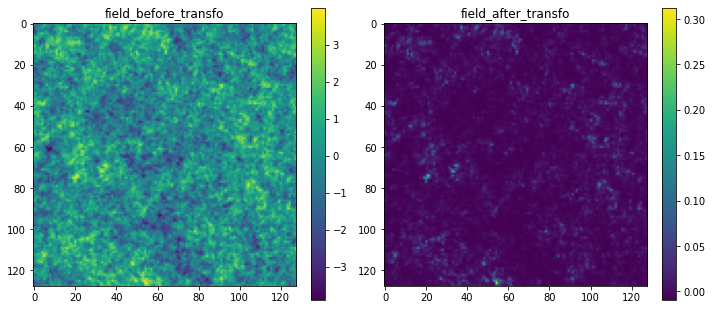

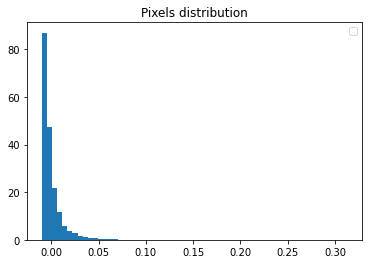

In [25]:
make_plot(jnp.linspace(0.01,0.01,64))

## Constant shift = 0.02

____variance of the field before transfo: 0.36415875


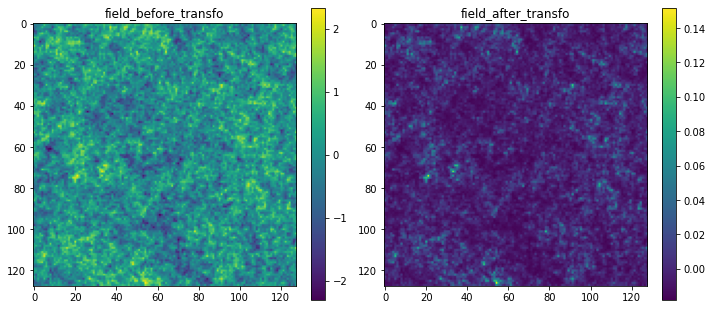

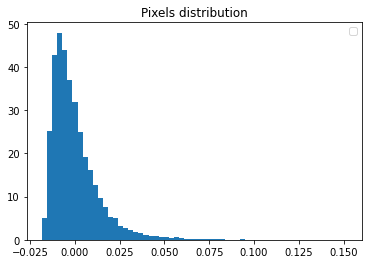

In [19]:
make_plot(jnp.linspace(0.02,0.02,64))

## Constant shift = 0.1

____variance of the field before transfo: 0.017200762


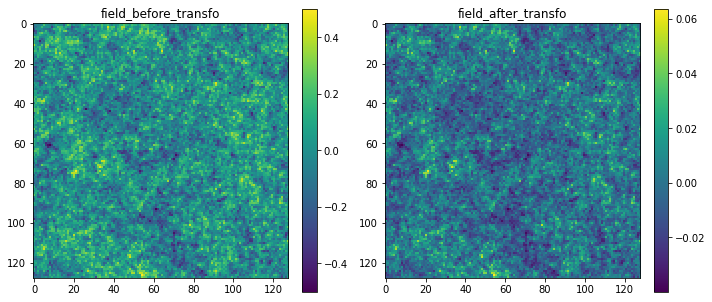

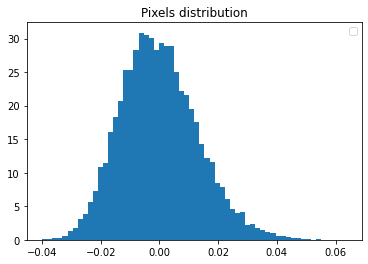

In [20]:
make_plot(jnp.linspace(0.1,0.1,64))

## Constant shift = 0.5

____variance of the field before transfo: 0.00069332065


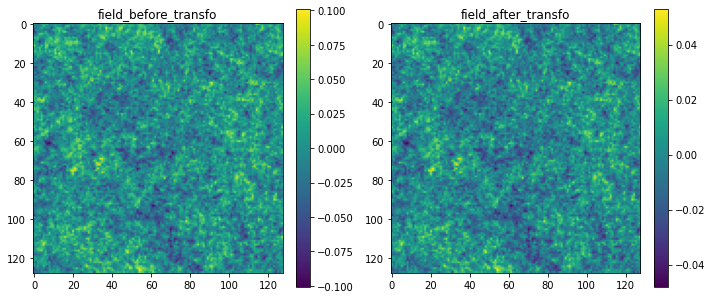

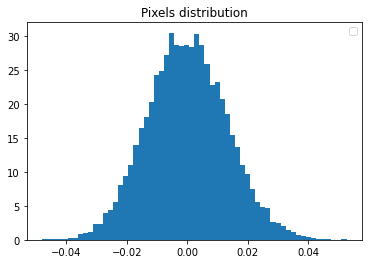

In [21]:
make_plot(jnp.linspace(0.5,0.5,64))

## Shift depends on parameters and go from 0.02 to 0.1

____variance of the field before transfo: 0.03180168


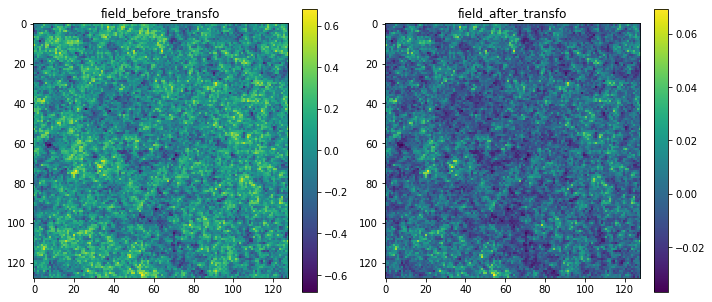

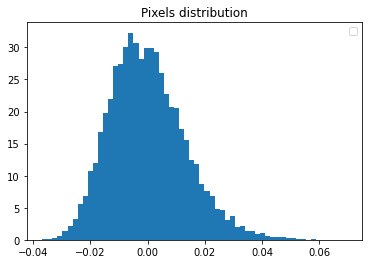

In [26]:
make_plot(jnp.linspace(0.02,0.1,64))

## Shift depends on parameters and go from 0.01 to 0.5



____variance of the field before transfo: 0.0015309857


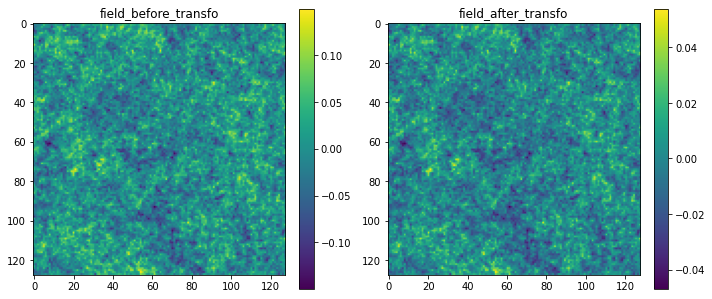

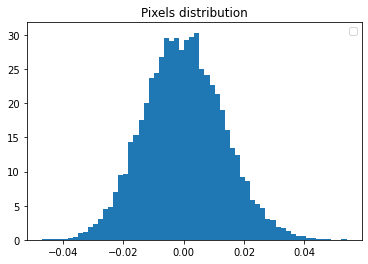

In [23]:
make_plot(jnp.linspace(0.01,0.5,64))

# Conclusion: 
- The bigger the variance the more non gaussianities (the tighter the contours should be but still have to confirm thta with mcmcs. 

  >  *UPDATE: the contours are not tighter. In [Supranta's paper](https://arxiv.org/pdf/2204.13216.pdf) Figure 10, they found the same thing).*



- The fact that the shift depends on the cosmological parameters does not induce more non-gaussinities. 
- BUT, the simple fact that we add additional information on the cosmological parameters (trought the shift) allow us to have tighter contours. 